In [20]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import pickle
import plotly.express as px
from plotly.offline import plot
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings 
import os

from src.PnsSim import (
    PnsSim
    )

In [ ]:
samples = [100, 300, 500, 1000, 1500, 2000, 3000, 6000]

data = []

for s in samples:
    sim = PnsSim(B = 500, N_o = s, N_e = s, N_i = 100000, Z_dim = 20, seed = 42)
    sim.generate_samples()
    PNS_l, PNS_u, dist_check_pass, _ ,_, _ = sim.fit()
    true_PNS_l, true_PNS_u, true_dist_check_pass, ATE, true_P_benefit, true_P_harm = sim.get_informer_data()
    
    data_dict  = {'samples' : s,
                  'PNS_l'   : PNS_l,
                  'PNS_u'   : PNS_u,
                  'dist_check_pass' : dist_check_pass,
                  'true_PNS_l' : true_PNS_l, 
                  'true_PNS_u' : true_PNS_u,
                  'true_dist_check_pass': true_dist_check_pass,
                  'ATE':ATE,
                  'true_P_benefit': true_P_benefit, 
                  'true_P_harm': true_P_harm}
    
    data.append(data_dict)

In [21]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [22]:
def dist_violation_pass_rate(data):
    samples = len(data) 
    total_pass = 0 
    total = 0
    for s in range(samples):
        total_pass += sum(data[s]['true_dist_check_pass'])
        total += len(data[s]['true_dist_check_pass'])
        
    return total_pass/total
    
dist_violation_pass_rate(data)

0.94175

/var/folders/18/8hrzln292yv90v6npz5xxbd80000gn/T/ipykernel_65553/3071865918.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/18/8hrzln292yv90v6npz5xxbd80000gn/T/ipykernel_65553/3071865918.py:87: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/18/8hrzln292yv90v6npz5xxbd80000gn/T/ipykernel_65553/3071865918.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

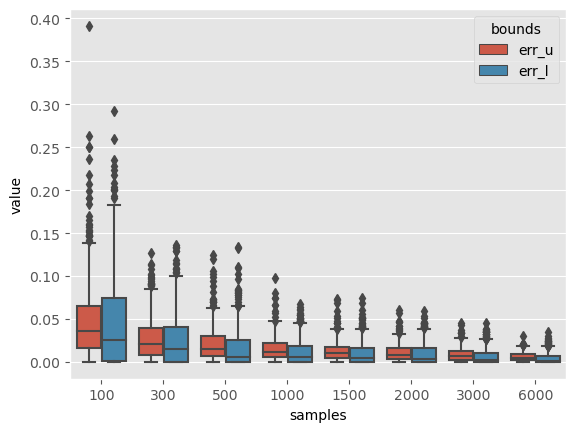

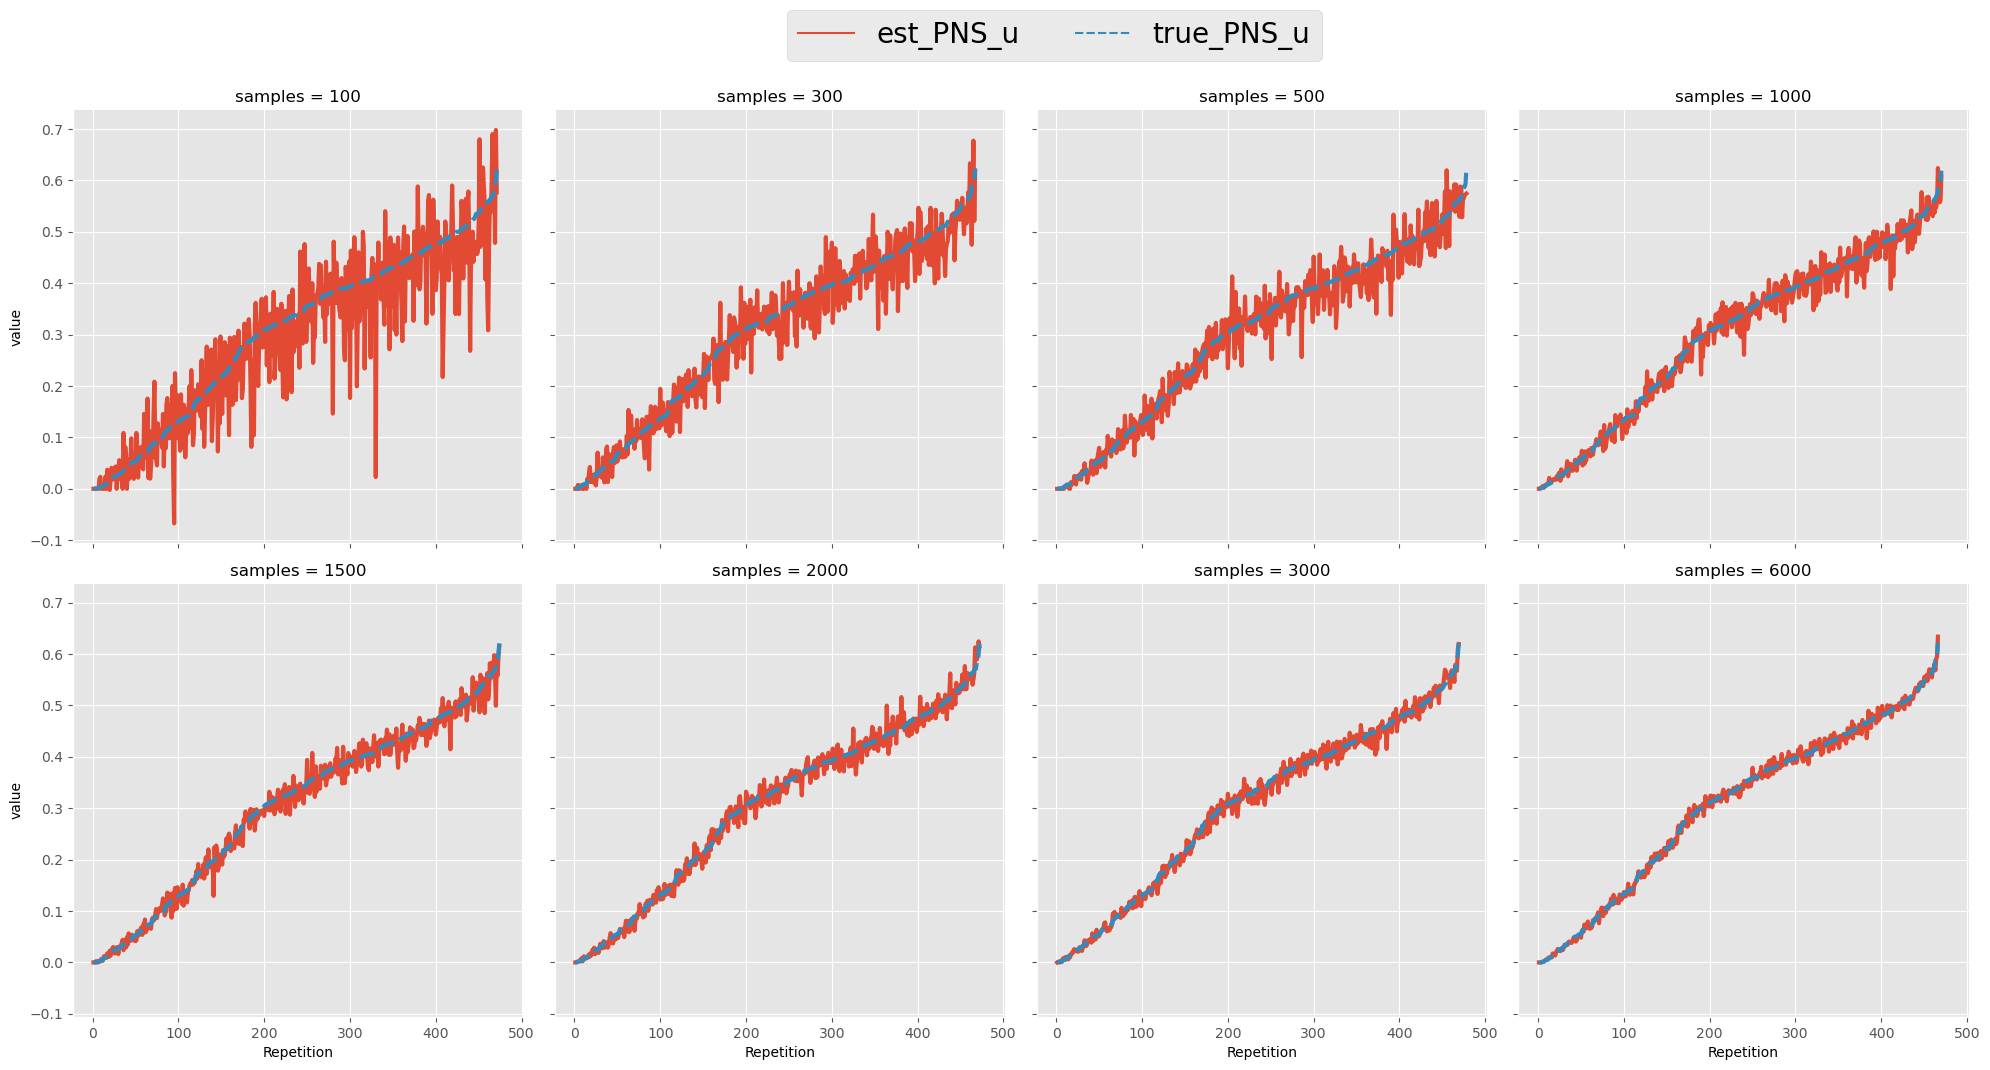

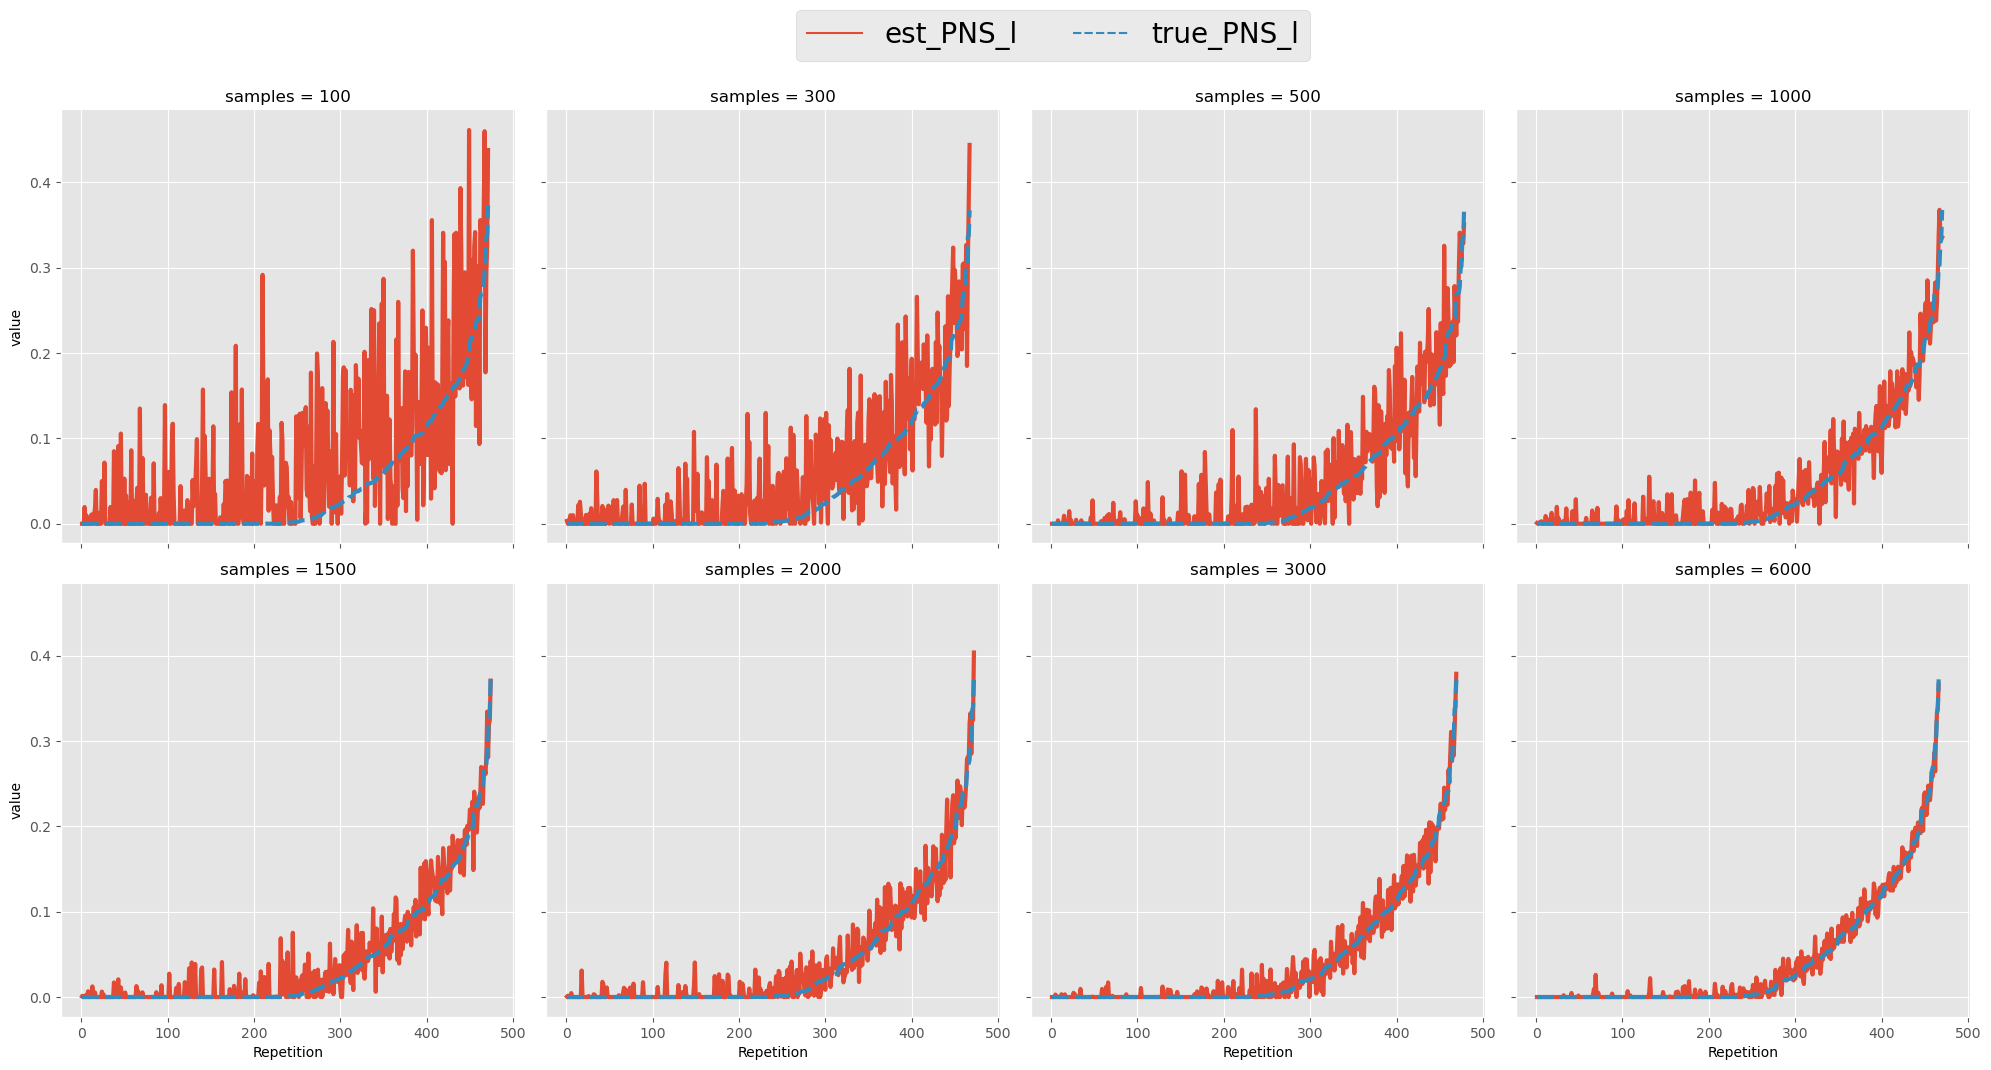

In [23]:
def summarize(data):
    
    result = []
    dfs = []
    
    sample_val = [data[i]['samples'] for i in range(len(data))]
    
    for s in range(len(sample_val)):
        
        PNS_u = data[s]['PNS_u']
        PNS_l = data[s]['PNS_l']
        
        true_PNS_u = data[s]['true_PNS_u']
        true_PNS_l = data[s]['true_PNS_l']
        
        true_P_benefit = data[s]['true_P_benefit']
        true_P_harm = data[s]['true_P_harm']
        ATE = data[s]['ATE']
        
        true_dist_check_pass = data[s]['true_dist_check_pass']
    
        # Apply filters
        
        f_PNS_u = np.array([i for (i, v) in zip(PNS_u, true_dist_check_pass) if v])
        f_PNS_l = np.array([i for (i, v) in zip(PNS_l, true_dist_check_pass) if v])
        f_true_PNS_u = np.array([i for (i, v) in zip(true_PNS_u, true_dist_check_pass) if v])
        f_true_PNS_l = np.array([i for (i, v) in zip(true_PNS_l, true_dist_check_pass) if v])   
        f_true_P_benefit = np.array([i for (i, v) in zip(true_P_benefit, true_dist_check_pass) if v]) 
        f_true_P_harm = np.array([i for (i, v) in zip(true_P_harm, true_dist_check_pass) if v]) 
        f_ATE =  np.array([i for (i, v) in zip(ATE, true_dist_check_pass) if v])        
        
        if not (len(f_PNS_u) == len(f_PNS_l) == len(f_true_PNS_u) == len(f_true_PNS_l)):
            print("Error")
            
        err_u = np.abs(f_PNS_u - f_true_PNS_u)
        err_l = np.abs(f_PNS_l - f_true_PNS_l)
        
        data_dict = {
            'samples' :  sample_val[s],
            'err_u' : err_u,
            'err_l': err_l,
            'f_PNS_u': f_PNS_u,
            'f_PNS_l': f_PNS_l,
            'f_true_PNS_u': f_true_PNS_u,
            'f_true_PNS_l': f_true_PNS_l,
            'f_true_P_benefit': f_true_P_benefit,
            'f_true_P_harm ': f_true_P_harm ,
            'f_ATE': f_ATE,
            }
        
        result.append(data_dict)
        
    for s in range(len(sample_val)):
        dfs.append(pd.DataFrame.from_dict(result[s]))
    df = pd.concat(dfs, axis=0, ignore_index=True)  
    
    df1 = df.copy()
    df2 = df.copy()
    
    df1['Rank'] = df1.groupby('samples')['f_true_PNS_u'].rank(method='max')  # You can change the ranking method
    df2['Rank'] = df2.groupby('samples')['f_true_PNS_l'].rank(method='max')  
    
    df1 = df1.sort_values(by = ['samples','f_true_PNS_u'],ascending=True)
    df2 = df1.sort_values(by = ['samples','f_true_PNS_l'],ascending=True)
    
    df1 = pd.melt(df1, id_vars=['samples'], var_name='bounds', value_name='value')
    df2 = pd.melt(df2, id_vars=['samples'], var_name='bounds', value_name='value')
    
    return df1, df2

# Summarize and Plot      

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 
df1, df2 = summarize(data)

# Plot 1
df_plot1 = df1[df1['bounds'].isin(['err_u', 'err_l'])]
sns.boxplot(data=df_plot1, x="samples", y="value", hue="bounds")

# Plot 2

df_plot2 = df1[df1['bounds'].isin(['f_true_PNS_u', 'f_PNS_u'])]
df_plot2['Repetition'] = df_plot2.groupby(['samples', 'bounds']).cumcount() + 1
df_plot2.reset_index()
df_plot2['bounds'] = df_plot2['bounds'].map({'f_PNS_u': 'est_PNS_u', 'f_true_PNS_u': 'true_PNS_u'})

ax0= sns.relplot(
    data=df_plot2, x='Repetition', y="value",linewidth = 3,
    hue="bounds", style="bounds", col="samples",
    col_wrap=4,
    kind="line"
)

sns.move_legend(
    ax0, "lower center",fontsize=20,
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=True,
)



# Plot 3

df_plot3 = df2[df2['bounds'].isin(['f_true_PNS_l', 'f_PNS_l' ])]
df_plot3['Repetition'] = df_plot3.groupby(['samples', 'bounds']).cumcount() + 1
df_plot3.reset_index()
df_plot3['bounds'] = df_plot3['bounds'].map({'f_PNS_l': 'est_PNS_l', 'f_true_PNS_l': 'true_PNS_l'})

ax = sns.relplot(
    data=df_plot3, x='Repetition', y="value",linewidth = 3,
    hue="bounds", style="bounds", col="samples",
    col_wrap=4, 
    kind="line", 
)

sns.move_legend(
    ax, "lower center",fontsize=20,
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=True,
)